## Decision Trees, Bagging, and Random Forest 

In this tutorial, we will implement Decision Trees for Classification and Regression from scratch. Next, we will highlight their shortcommings through the Bias-Variance Decomposition. Finaly, we will show how the Random Forest algoorthm emerges from Bagging and Decision Trees.


This tutorial is based on amazing lectures of Kilian Weinberger
[Lecture 17](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote17.html) and 
[Lecture 18](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote18.html). 

### Motivation for Decision Trees
Advantages of kNN
In low dimensions kNN is actually quite powerful 
1. It can learn non-linear decision boundaries and 
2. It can handle multi-class problems. 
Disadvantages
1. kNN needs the entire training data stored, i.e,. it requires a lot of storage
2. As the size of training data increases$ testing time increases as we need to compute distances to all training inputs, 
3. We need to find a good distance metric.


__Decision trees__ do not need even a single training data stored. Instead, we store learned rules. More specifically, we use the training data to build a tree structure that recursively divides the space into regions with similar labels.

# Decision Tree

### SETUP
$\mathcal D = \{ (x_i,y_i) \}_{i=1} ^n ,$ where $y_i \in \{1,\dots,c\}$. Let $\mathcal D_k \subseteq \mathcal D$, where $\mathcal D_k = \{(x,y) \in \mathcal D : y=k \}$ all inputs with label $k$.

The fract of inputs in the dataset with label $k$ is computed as 
$$ p_k = \frac{|\mathcal D_k |}{ | \mathcal D |}$$


## Gini Impurity

$$ G(\mathcal D) = \sum_{k=1} ^c p_k (1 - p_k)$$
Note that $c$ is the number of classes.

Text(0.5, 1.0, 'Gini Impurity Binary 2p(1-p)')

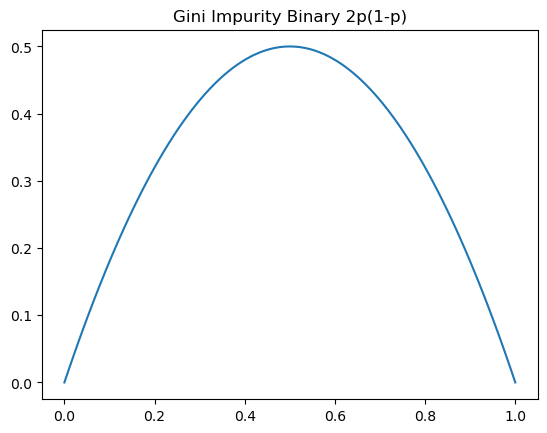

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris,load_diabetes
import pandas as pd

p=np.linspace(0, 1, 100, endpoint=True)
np.sum(p*(1-p))
plt.plot(p,2*p*(1-p))
plt.title('Gini Impurity Binary 2p(1-p)')

In [2]:
data=load_iris()
data.keys()
X=pd.DataFrame(data['data'],columns=data['feature_names'])
y=pd.Series(data['target'])
del data
# Easy selecting
def rename_columns(x):
    x=x.replace(' (cm)','')
    return x.replace(" ", "_")
X.columns=pd.Index(rename_columns(x) for x in X.columns) 
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


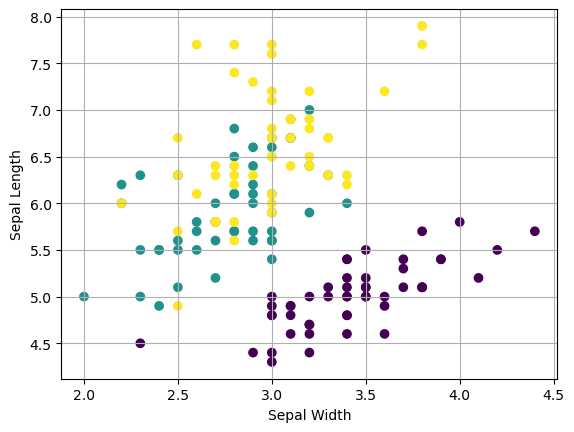

In [3]:
plt.scatter(X.sepal_width,X.sepal_length,c=y)
plt.xlabel('Sepal Width')
plt.ylabel('Sepal Length')
plt.grid()

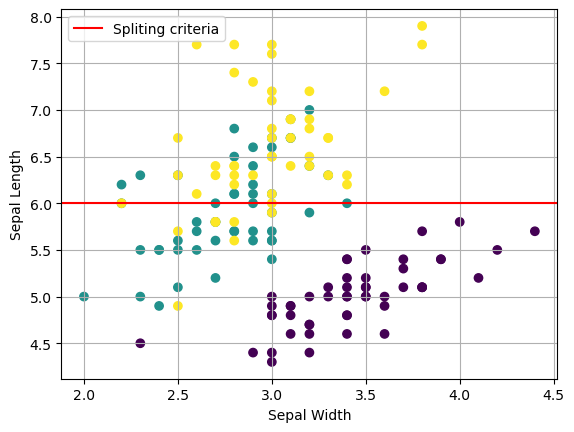

In [4]:
# The spliting cretarion and the value 
sepal_length_split = 6.0

# Ploting the original plot
plt.scatter(X.sepal_width,X.sepal_length,c=y)
plt.xlabel('Sepal Width')
plt.ylabel('Sepal Length')
plt.grid()

plt.axhline(sepal_length_split, label='Spliting criteria', color='red')
plt.legend()
plt.show()

In [5]:
def gini_impurity(y):
  '''
  Given a Pandas Series, it calculates the Gini Impurity. 
  y: variable with which calculate Gini Impurity.
  '''
  if isinstance(y, pd.Series):
    # Probability of class label k
    p_k=y.value_counts()/y.shape[0]
    return (p_k*(1-p_k)).sum()
  else:
    raise('Object must be a Pandas Series.')

In [6]:
gini_impurity(y)

0.6666666666666667

In [7]:
# Left Split
gini_impurity(y[X[X['sepal_length']<=sepal_length_split].index])

0.5605352859487438

In [8]:
# Right Split
gini_impurity(y[X[X['sepal_length']>sepal_length_split].index])

0.44074173609244827

$$ \text{Going on direction where sepal length is larger than its mean is advantages}$$

In [9]:
class DecisionClassificationNode:
    def __init__(self, *, id, max_depth, depth):
        self.id = id
        self.max_depth = max_depth
        self.depth = depth
        self.left, self.right = None, None
        self.best_feature, self.feature_val = None, None
        self.gini_gain = None
        self.class_probability = dict()
        self.yhat = None

    def __str__(self):
        m = f'{self.id}\tDepth:{self.depth}\tFeature:{self.best_feature}\t'
        if self.feature_val is not None:
            m += f'Val:{self.feature_val:.3f}\tGiniGain:{self.gini_gain:.3f}\tPred:{self.class_probability}'
        return m

    @staticmethod
    def best_split(X, y):
        features = list(X.columns)

        df = X.copy()
        y = y.copy()
        df['y'] = y

        max_gain = 0
        best_feature = None
        best_feature_avg = None

        for feature in features:

            gini_base = gini_impurity(y)
            mean_of_feature = df[feature].mean()

            dfleft, dfright = df[df[feature] <= mean_of_feature], df[df[feature] > mean_of_feature]

            lleft, lright = len(dfleft), len(dfright)
            lenght = lleft + lright

            w_left, w_right = lleft / lenght, lright / lenght

            gini_left, gini_right = gini_impurity(dfleft['y']), gini_impurity(dfright['y'])
            # Calculating the weighted GINI impurity
            weighted_gini = w_left * gini_left + w_right * gini_right
            gini_gain = gini_base - weighted_gini
            # print(
            #    f'Feature:{feature}\t Mean Value:{mean_of_feature:.3f},\t Weighted Gini:{weighted_gini:.3f},\t Gini Gain:{gini_gain:.3f}')
            if gini_gain > max_gain:
                best_feature = feature
                best_feature_avg = mean_of_feature
                # Setting the best gain to the current one
                max_gain = gini_gain
        return best_feature, best_feature_avg, max_gain

    def fit(self, X, y):
        features = list(X.columns)
        self.best_feature, self.feature_val, self.gini_gain = self.best_split(X, y)
        self.yhat = y.value_counts() / len(y)

        # print(f'Feature:{feature}\t Mean Value:{mean_of_feature:.3f},\t Weighted Gini:{weighted_gini:.3f},\t Gini Gain:{gini_gain:.3f}')

        df = X.copy()
        y = y.copy()
        df['y'] = y
        if self.depth > self.max_depth or (self.best_feature is None):
            return self

        dfleft, dfright = df[df[self.best_feature] <= self.feature_val], df[
            df[self.best_feature] > self.feature_val]

        left_classes = dfleft['y'].value_counts().index.to_list()
        left_probs = (dfleft['y'].value_counts() / len(dfleft)).to_list()
        self.class_probability['Left'] = dict(zip(left_classes, left_probs))

        right_classes = dfright['y'].value_counts().index.to_list()
        right_probs = (dfright['y'].value_counts() / len(dfright)).to_list()

        self.class_probability['Right'] = dict(zip(right_classes, right_probs))
        self.left = DecisionClassificationNode(id=self.id + '_left', max_depth=self.max_depth, depth=self.depth + 1).fit(
            dfleft[features], dfleft['y'])
        self.right = DecisionClassificationNode(id=self.id + '_right', max_depth=self.max_depth, depth=self.depth + 1).fit(
            dfright[features], dfright['y'])
        # IF we reach here, then stopping criteria is fulfilled
        return self

    def predict(self, x):
        if self.best_feature is None:
            label, prob = self.yhat.index.values, self.yhat.values
            return label[prob.argmax()]

        boolean_output = x[self.best_feature] <= self.feature_val

        if boolean_output and self.left is not None:
            # Turn Left
            return self.left.predict(x)
        elif (boolean_output == False) and self.right is not None:
            # turn Right
            return self.right.predict(x)
        else:
            label, prob = self.yhat.index.values, self.yhat.values
            return label[prob.argmax()]

In [10]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.X, self.y = None, None
        self.features = None
        # Saving the hyper parameters
        self.max_depth = max_depth if max_depth else 200
        self.root = None

    def fit(self, X, y,type_of_node=None):
        self.root = type_of_node(id='Root', max_depth=self.max_depth, depth=0).fit(X.copy(), y.copy())
        return self

    def __str__(self):
        return str(self.root)

    def predict(self, X):
        preds = []
        for index, x in X.iterrows():
            preds.append(self.root.predict(x))
        return np.array(preds).flatten()

#### Max depth = 1

In [11]:
preds = DecisionTree(max_depth=1).fit(X, y,DecisionClassificationNode).predict(X)
print((preds == y).mean())

0.9466666666666667


#### Max depth = 2

In [12]:
preds = DecisionTree(max_depth=3).fit(X, y,DecisionClassificationNode).predict(X)
print((preds == y).mean())

0.96


#### Max depth = 3

In [13]:
preds = DecisionTree(max_depth=3).fit(X, y,DecisionClassificationNode).predict(X)
print((preds == y).mean())

0.96


#### Max depth = 5

In [14]:
preds = DecisionTree(max_depth=5).fit(X, y,DecisionClassificationNode).predict(X)
print((preds == y).mean())

0.98


#### Max depth = 10

In [15]:
preds = DecisionTree(max_depth=10).fit(X, y,DecisionClassificationNode).predict(X)
print((preds == y).mean())

1.0


### Using scikit-learn for Visualization

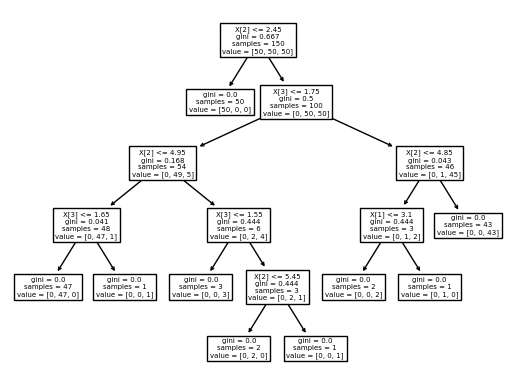

In [16]:
from sklearn import tree
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)
tree.plot_tree(clf);

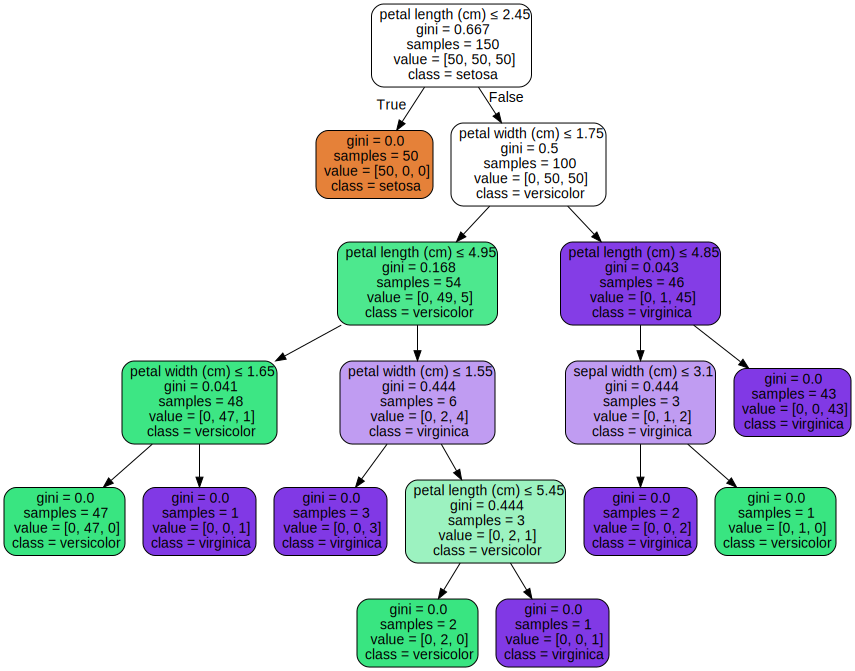

In [17]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=iris.feature_names,  
                                class_names=iris.target_names,  
                                filled=True, rounded=True,  special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Predictions are very interpretable aren't they :) 

# Decision Regression Tree

$$ \mathcal L (S) = \frac{1}{|S|} \sum_{(x_i, y_i ) \in S} (y - \mu)^2$$
where $\mu = \frac{1}{|S|} \sum_{(x_i, y_i ) \in S} y_i$

### Runtime Complexity in training

Cost of constructing a decision $$ \mathcal O (|\mathcal D| \times |d| \times log(|\mathcal D|)),\; \text{ where } \forall i x_i \in \mathbb R ^d $$

Cost of constructing a decision Tree $$ \mathcal O (|\mathcal D|^2 \times |d| \times log(|\mathcal D|)),\; \text{ where } \forall i x_i \in \mathbb R ^d $$


[By using this heuristic](https://youtu.be/0LB1cy2sCXc?t=1027), we would get $$ \mathcal O (|\mathcal D| \times |d| \times log(|\mathcal D|))$$

### Runtime Prediction 

$$ \mathcal O (log(|\mathcal D|))$$



In [18]:
data = load_diabetes()
data.keys()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
del data
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [19]:
def avg_squared_difference(y):
    if isinstance(y, pd.Series):
        return np.mean((y - y.mean()) ** 2)
    else:
        raise ('Object must be a Pandas Series.')


class DecisionRegressionNode:
    def __init__(self, *, id, max_depth, depth):
        self.id = id
        self.max_depth = max_depth
        self.depth = depth
        self.left, self.right = None, None
        self.best_feature, self.feature_val = None, None
        self.gini_gain = None
        self.class_probability = dict()
        self.yhat = None

    def __str__(self):
        m = f'{self.id}\tDepth:{self.depth}\tFeature:{self.best_feature}\t'
        if self.feature_val is not None:
            m += f'Val:{self.feature_val:.3f}\tGiniGain:{self.gini_gain:.3f}\tPred:{self.class_probability}'
        return m

    @staticmethod
    def best_split(X, y):
        features = list(X.columns)

        df = X.copy()
        y = y.copy()
        df['y'] = y

        max_gain = 0
        best_feature = None
        best_feature_avg = None

        for feature in features:

            gini_base = avg_squared_difference(y)
            mean_of_feature = df[feature].mean()

            dfleft, dfright = df[df[feature] <= mean_of_feature], df[df[feature] > mean_of_feature]

            lleft, lright = len(dfleft), len(dfright)
            lenght = lleft + lright

            w_left, w_right = lleft / lenght, lright / lenght

            gini_left, gini_right = avg_squared_difference(dfleft['y']), avg_squared_difference(dfright['y'])
            # Calculating the weighted GINI impurity
            weighted_gini = w_left * gini_left + w_right * gini_right
            gini_gain = gini_base - weighted_gini
            # print(
            #    f'Feature:{feature}\t Mean Value:{mean_of_feature:.3f},\t Weighted Gini:{weighted_gini:.3f},\t Gini Gain:{gini_gain:.3f}')
            if gini_gain > max_gain:
                best_feature = feature
                best_feature_avg = mean_of_feature
                # Setting the best gain to the current one
                max_gain = gini_gain
        return best_feature, best_feature_avg, max_gain

    def fit(self, X, y):
        features = list(X.columns)
        self.best_feature, self.feature_val, self.gini_gain = self.best_split(X, y)
        self.yhat = y.mean()

        df = X.copy()
        y = y.copy()
        df['y'] = y
        if self.depth > self.max_depth or (self.best_feature is None):
            return self

        dfleft, dfright = df[df[self.best_feature] <= self.feature_val], df[
            df[self.best_feature] > self.feature_val]

        left_classes = dfleft['y'].value_counts().index.to_list()
        left_probs = (dfleft['y'].value_counts() / len(dfleft)).to_list()
        self.class_probability['Left'] = dict(zip(left_classes, left_probs))

        right_classes = dfright['y'].value_counts().index.to_list()
        right_probs = (dfright['y'].value_counts() / len(dfright)).to_list()

        self.class_probability['Right'] = dict(zip(right_classes, right_probs))
        self.left = DecisionRegressionNode(id=self.id + '_left', max_depth=self.max_depth, depth=self.depth + 1).fit(
            dfleft[features], dfleft['y'])
        self.right = DecisionRegressionNode(id=self.id + '_right', max_depth=self.max_depth, depth=self.depth + 1).fit(
            dfright[features], dfright['y'])
        # IF we reach here, then stopping criteria is fulfilled
        return self

    def predict(self, x):
        if self.best_feature is None:
            return  self.yhat.mean()

        boolean_output = x[self.best_feature] <= self.feature_val

        if boolean_output and self.left is not None:
            # Turn Left
            return self.left.predict(x)
        elif (boolean_output == False) and self.right is not None:
            # turn Right
            return self.right.predict(x)
        else:
            return self.yhat.mean()


In [20]:
data = load_diabetes()
data.keys()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
del data
X.columns = pd.Index(rename_columns(x) for x in X.columns)
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [21]:
y

0      151.0
1       75.0
2      141.0
3      206.0
4      135.0
       ...  
437    178.0
438    104.0
439    132.0
440    220.0
441     57.0
Length: 442, dtype: float64

#### Max depth = 1

In [22]:
preds = DecisionTree(max_depth=1).fit(X, y,type_of_node=DecisionRegressionNode).predict(X)
avg_squared_difference(y-preds)

3622.711742378153

#### Max depth = 3

In [23]:
preds = DecisionTree(max_depth=3).fit(X, y,type_of_node=DecisionRegressionNode).predict(X)
avg_squared_difference(y-preds)

2910.8226603045914

#### Max depth = 5

In [24]:
preds = DecisionTree(max_depth=5).fit(X, y,type_of_node=DecisionRegressionNode).predict(X)
avg_squared_difference(y-preds)

1958.2496839949893

#### Max depth = 10

In [25]:
preds = DecisionTree(max_depth=10).fit(X, y,type_of_node=DecisionRegressionNode).predict(X)
avg_squared_difference(y-preds)

2.1006787330316743

#### Max depth = 15

In [26]:
preds = DecisionTree(max_depth=15).fit(X, y,type_of_node=DecisionRegressionNode).predict(X)
avg_squared_difference(y-preds)

0.0

# Bias-Variance Decomposition



Increasing max depth in Decision Trees should ring bells for overfitting, i.e,. __increasing the variance part of bias-variance decomposition__.


1- Predictions of decision trees are neither __smooth__ nor __continuous__, but piecewise constant approximations
2. There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems

# Bagging (Bootstraph Aggregating)

### Recall The Bias-Variance Decomposition

$$
\begin{equation*}
    \underbrace{\mathbb{E}[(h_D(x) - y)^2]}_\mathrm{Error} = \underbrace{\mathbb{E}[(h_D(x)-\bar{h}(x))^2]}_\mathrm{Variance} + \underbrace{\mathbb{E}[(\bar{h}(x)-\bar{y}(x))^2]}_\mathrm{Bias} + \underbrace{\mathbb{E}[(\bar{y}(x)-y(x))^2]}_\mathrm{Noise}
\end{equation*}
$$

Our goal is to reduce the variance term: $\mathbb{E}[(h_D(x)-\bar{h}(x))^2]$. Hence, $ h_D \to \bar{h}$

### Weak law of large numbers

the weak law of large numbers says (roughly) for i.i.d. random variables $x_i$ with mean  $\bar{x}$
$$ \frac{1}{m}\sum_{i = 1}^{m}x_i \rightarrow \bar{x} \textrm{ as }  m\rightarrow \infty$$

Assume that we have $\mathcal D_i, \dots \mathcal D_n$ drawn from $\mathbb P ^n(\mathcal X, \mathcal Y)$

$$ \hat{h} = \frac{1}{m}\sum_{i = 1}^m h_{D_i} \to \bar{h} \qquad as\  m \to \infty $$

### Prediction: Averaging m classifiers


$$ \hat{h}_D(x) = \frac{1}{m}\sum_{i = 1}^{m}h_{D_i}(x) $$

## Creating bootstraph dataset

Create them by drawing uniformly with replacement from the origially given set $\mathcal D$


1. Reduces variance, so has a strong beneficial effect on high variance classifiers.
2. As the prediction is an average of many classifiers, you obtain a mean score and variance.
3. Bagging provides an unbiased estimate of the test error, which we refer to as the __out-of-bag error__. 



### Out-of-Bag Error
$$ \forall (\mathbf{x}_i,y_i)\in D \\ \tilde 
S_i=\{k| (\mathbf{x}_i,y_i)\notin D_k\}$$


$S_i$ is a set of all the training sets $D_k$ not containing $(x_k ,y_k)$

$$ \\
h_i(\mathbf{x})=\frac{1}{|S_i|}\sum_{k\in S_i}h_k(\mathbf{x}). $$

$$ \\ \epsilon_\mathrm{OOB}=\frac{1}{n}\sum_{(\mathbf{x}_i, y_i) \in D}l(\tilde h_i(\mathbf{x_i}),y_i) $$
The idea is that each training point was not picked and all the data sets Dk. If we average the classifiers hk of all such data sets, we obtain a classifier (with a slightly smaller m) that was not trained on (xi,yi) ever and it is therefore equivalent to a test sample. If we compute the error of all these classifiers, we obtain an estimate of the true test error. The beauty is that we can do this without reducing the training set. We just run bagging as it is intended and obtain this so called out-of-bag error for free

### Feature Selection

1. Train Random Forest.
2. Look at whenever you split a feature how much impurity goes down.
3. Rank those splits.
4. You got the most important features.

# Random Forest

https://link.springer.com/article/10.1023/A:1010933404324

1. Create m datasest with replacement
2. Train $m$ decision tree. Perform each split by considering only $k=\sqrt{d}$ randomly selected features
3. Final classifier : $ h(\mathbf{x})=\frac{1}{m}\sum_{j=1}^m h_j(\mathbf{x})$

Set m as big as you can store in your machine.

## [Kilian Weinberger](https://www.youtube.com/watch?v=4EOCQJgqAOY&list=PLl8OlHZGYOQ7bkVbuRthEsaLr7bONzbXS&index=31) $$ \text{Most of the time RF is the second best algorithm}$$

# TODOs
Intread key messages from scikit learn blogs

1. https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_0_24_0.html#individual-conditional-expectation-plots

2. https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py

3. https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py

4. https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

5. https://scikit-learn.org/stable/common_pitfalls.html#common-pitfalls